In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.data import sciensano
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
# Number of age groups used in the model
age_stratification_size=10
# Startdate of model
start_date = '2020-03-15'

In [3]:
#model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size, start_date=start_date, update_data=False)

In [14]:
agg=None
age_classes=pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')
df = sciensano.get_public_spatial_vaccination_data(agg=agg, update=False)
df = df['INCIDENCE']

## Part 1: N_vacc function

In [5]:
from covid19model.models.time_dependant_parameter_fncs import make_N_vacc_function

In [6]:
# Slice dataset to a moment before the booster campaign
start_booster = '2022-05-02'#'2021-10-04'
df_incidences = df.loc[slice('2020-12-28',start_booster), slice(None), slice(None)]
# Initialize TDPF
output = make_N_vacc_function(agg=agg, df_incidences=df_incidences, hypothetical_function=False)

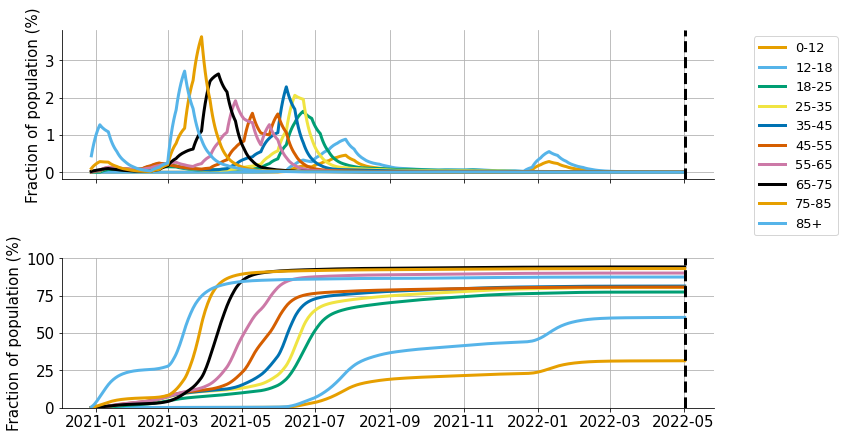

In [7]:
from covid19model.data.model_parameters import construct_initN
N = construct_initN(age_classes, None).values
data = output.df
dose='A'

fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(12,6), sharex=True)

for idx, age_class in enumerate(age_classes):
    ax[0].plot(data.loc[slice(None),age_class,dose]/N[idx]*100)
    ax[1].plot(data.loc[slice(None),age_class,dose].cumsum()/N[idx]*100)

ax[0].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')
ax[1].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')

ax[0].set_ylabel('Fraction of population (%)')
ax[1].set_ylabel('Fraction of population (%)')

ax[1].set_ylim([0,100])


legend_text=['0-12', '12-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85', '85+']
ax[0].legend(legend_text, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

plt.tight_layout()
#plt.savefig('hypothetical_booster_campaign_refusal10_30000.png', dpi=400)
plt.show()
plt.close()

## Part 2: rescaling function for waning

In [47]:
from covid19model.models.time_dependant_parameter_fncs import make_vaccination_rescaling_function
from covid19model.data.model_parameters import get_COVID19_SEIQRD_VOC_parameters

In [48]:
agg=None
age_classes=pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')
df = sciensano.get_public_spatial_vaccination_data(agg=agg, update=False)
df = df['INCIDENCE']
# Load currently saved VOC parameters
VOC_params, vaccine_params = get_COVID19_SEIQRD_VOC_parameters()

In [ ]:
make_vaccination_rescaling_function(update=True, agg=agg, age_classes=age_classes, df_incidences=df,
                                    VOC_function=None, vaccine_params=vaccine_params)

/tmp/ipykernel_1029347/3305622425.py:1: UserWarning: The vaccination rescaling parameters must be updated because a change was made to the desired VOCs or vaccination parameters, this may take some time.
  make_vaccination_rescaling_function(update=True, agg=agg, age_classes=age_classes, df_incidences=df,
